In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import scipy.stats as st

In [78]:
# plots linear regression line and returns pearson correlation
def plot_linregress(x_values, y_values, x_label, y_label):
    plt.scatter(x_values, y_values)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    (slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    plt.plot(x_values,regress_values,"r-")
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.annotate(line_eq, (min(x_values), min(y_values)),fontsize=18,color="red")
    return abs(st.pearsonr(x_values, y_values)[0])

In [2]:
# import data
gaming_data = pd.read_csv('data_cleanup/Gaming.csv', encoding='UTF-8')


Terminology:
- GAD-7 is the Generalized Anxiety Disorder survey used as an initial screening tool for generalized anxiety disorder. Each item is statement where scored from 0-3. with 0 being little to no anxiety, 3 being the most anxious.
    - Anxiety severity scale: (https://patient.info/doctor/generalised-anxiety-disorder-assessment-gad-7)
        - 0-4: No anxiety
        - 5-9: Mild anxiety
        - 10-14: Moderate anxiety
        - 15-21: Severe anxiety
- SWL is the Satisfaction with Life Scale. Each item is statement scored from 1-7. 1 being unsatisfied, 7 being ideal.
    - SWL Scale: https://positivepsychology.com/life-satisfaction-scales/
        - 31–35 = Extremely satisfied
        - 26–30 = Satisfied
        - 21–25 = Slightly satisfied
        - 20 = Neutral
        - 15–19 = Slightly dissatisfied
        - 10–14 = Dissatisfied
        - 5–9 = Extremely dissatisfied
- SPIN is the Social Phobia Inventory. Each item is a statement scored from 0-4. 0 being unbothered, 4 being most bothered.
    - SPIN Scale: (https://www.verywellhealth.com/social-phobia-inventory-test-5271967)
        - No social anxiety (0-20)
        - Mild (21-30)
        - Moderate (31-40)
        - Severe (41-50)
        - Very severe (51-68)

Hypotheses:
1) Does playing League of Legends correlate with 5-19 SWL (dissatisfied with life)?
    - League of Legends is known to have many toxic players. players are given many ways to socially disengage from the other players, i.e. muting chat and emotes, restricting chat access to different levels
    - initial hypothesis is that league players generally have a lower SWL (which is why they're generally unkind)
2) Do players who gravitate towards RPG games score moderately on GAD (10-21) or SPIN (31-68) scores?
    - initial hypothesis is that players who play RPG games typically have higher anxiety (general or social), and it fulfills the human need for interaction

In [3]:
# trim data
age_data = gaming_data[['Entry', 'Gender', 'Age', 'Game', 'Hours per Week', 
            'GAD1', 'GAD2', 'GAD3', 'GAD4', 'GAD5', 'GAD6', 'GAD7', 'GAD Total', 
            'SWL1', 'SWL2', 'SWL3', 'SWL4', 'SWL5', 'SWL Total',
            'SPIN1', 'SPIN2', 'SPIN3', 'SPIN4', 'SPIN5', 'SPIN6', 'SPIN7', 'SPIN8',
            'SPIN9', 'SPIN10', 'SPIN11', 'SPIN12', 'SPIN13', 'SPIN14', 'SPIN15',
            'SPIN16', 'SPIN17', 'SPIN Total']]

age_data.head()

,Entry,Gender,Age,Game,Hours per Week,GAD1,GAD2,GAD3,GAD4,GAD5,...,SPIN9,SPIN10,SPIN11,SPIN12,SPIN13,SPIN14,SPIN15,SPIN16,SPIN17,SPIN Total
0,1,Male,25,Skyrim,15,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,5
1,2,Male,41,Other,8,1,2,2,2,0,...,4,0,3,0,1,3,3,1,2,33
2,3,Female,32,Other,0,0,2,2,0,0,...,0,1,1,3,0,2,4,4,2,31
3,4,Male,28,Other,20,0,0,0,0,0,...,0,0,1,3,0,0,1,0,0,11
4,5,Male,19,Other,20,2,1,2,2,2,...,2,0,1,0,0,0,0,3,0,13


In [13]:
# Categorize games
age_data['Category'] = ''
for index, row in age_data.iterrows():
    switch={
        'League of Legends': 'MOBA', 
        'Other': 'N/A', 
        'Starcraft 2' : 'RTS', 
        'Counter Strike':'FPS',
        'World of Warcraft':'MMORPG', 
        'Hearthstone':'CCG', 
        'Diablo 3':'RPG', 
        'Heroes of the Storm':'MOBA',
        'Guild Wars 2':'MMMORPG', 
        'Skyrim':'RPG', 
        'Destiny':'FPS'
    }
    age_data.loc[index, 'Category'] = switch.get(age_data.loc[index, 'Game'])

In [16]:
# Create age bins
bins = [18, 21, 25, 30, 35, 40, 50, 60]

# Create labels for said bins
group_labels = ["18 to 21", "22 to 25", "26 to 30", "31 to 35", "36 to 40", "41 to 50", "51 to 60"]

# Bin the data
age_data["Age Group"] = pd.cut(age_data["Age"], bins, labels=group_labels)


In [17]:
# Reorganize DataFrame
age_data = age_data[['Entry', 'Gender', 'Age Group', 'Age', 'Game', 'Category', 'Hours per Week', 
            'GAD1', 'GAD2', 'GAD3', 'GAD4', 'GAD5', 'GAD6', 'GAD7', 'GAD Total', 
            'SWL1', 'SWL2', 'SWL3', 'SWL4', 'SWL5', 'SWL Total',
            'SPIN1', 'SPIN2', 'SPIN3', 'SPIN4', 'SPIN5', 'SPIN6', 'SPIN7', 'SPIN8',
            'SPIN9', 'SPIN10', 'SPIN11', 'SPIN12', 'SPIN13', 'SPIN14', 'SPIN15',
            'SPIN16', 'SPIN17', 'SPIN Total']]
age_data

,Entry,Gender,Age Group,Age,Game,Category,Hours per Week,GAD1,GAD2,GAD3,...,SPIN9,SPIN10,SPIN11,SPIN12,SPIN13,SPIN14,SPIN15,SPIN16,SPIN17,SPIN Total
0,1,Male,22 to 25,25,Skyrim,RPG,15,0,0,0,...,0,0,0,0,0,1,0,1,0,5
1,2,Male,41 to 50,41,Other,N/A,8,1,2,2,...,4,0,3,0,1,3,3,1,2,33
2,3,Female,31 to 35,32,Other,N/A,0,0,2,2,...,0,1,1,3,0,2,4,4,2,31
3,4,Male,26 to 30,28,Other,N/A,20,0,0,0,...,0,0,1,3,0,0,1,0,0,11
4,5,Male,18 to 21,19,Other,N/A,20,2,1,2,...,2,0,1,0,0,0,0,3,0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11133,14246,Male,22 to 25,22,Other,N/A,40,1,0,0,...,0,0,0,0,0,0,1,0,0,7
11134,14247,Female,18 to 21,20,League of Legends,MOBA,20,3,3,3,...,2,1,4,0,2,2,1,0,1,25
11135,14248,Male,18 to 21,19,Starcraft 2,RTS,20,0,0,0,...,0,1,1,1,0,1,0,0,0,10
11136,14249,Female,NaN,18,Other,N/A,5,3,2,1,...,4,1,3,1,0,3,2,0,1,32


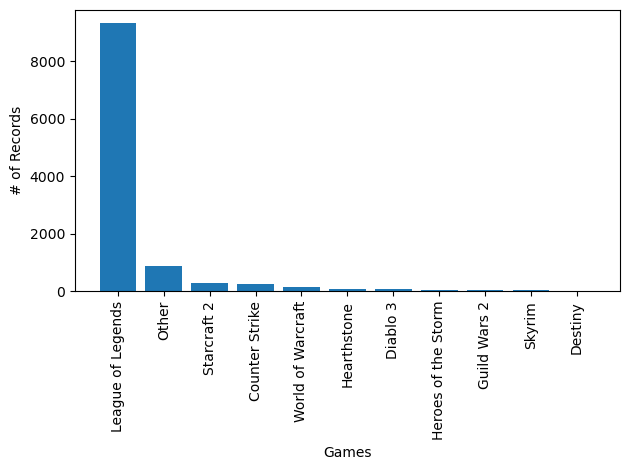

In [5]:
# show game data skew
games_only = age_data['Game'].value_counts()
# plot games data to visualize. chose 
plt.bar(games_only.index, games_only)
plt.ylabel('# of Records')
plt.xlabel('Games')
plt.xticks(rotation=90)
plt.tight_layout()

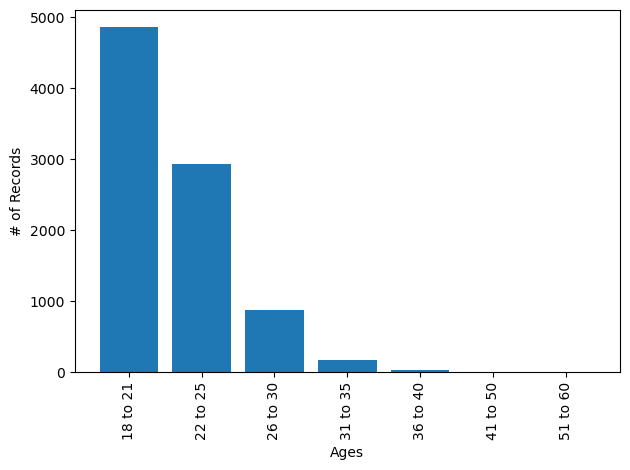

In [29]:
# ===============================
# PERHAPS DISCARD THIS ONE
# ===============================

# show age data skew
age_only = age_data['Age Group'].value_counts()
# plot games data to visualize. chose 
plt.bar(age_only.index, age_only)
plt.ylabel('# of Records')
plt.xlabel('Ages')
plt.xticks(rotation=90)
plt.tight_layout()

0.2834839408712678

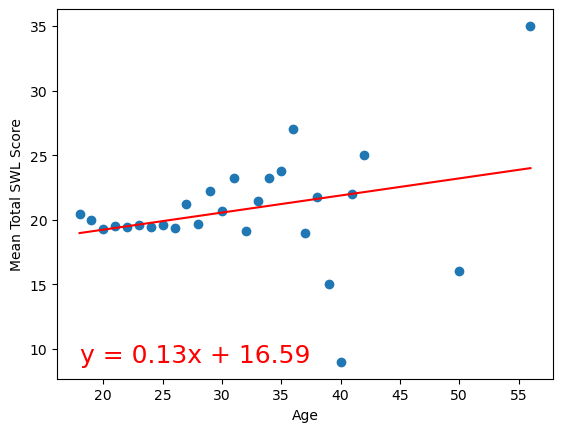

In [84]:
# look at mean SWL Total by age group
league_data = age_data[age_data['Game'] == 'League of Legends']
swl_lol_summary = league_data.groupby('Age')['SWL Total']
agg_swl_lol = swl_lol_summary.agg(['mean', 'median', 'var', 'std', 'sem'])
plot_linregress(agg_swl_lol.index, agg_swl_lol['mean'],'Age', 'Mean Total SWL Score')
# plt.scatter(agg_swl_lol.index, agg_swl_lol['mean'])
# plt.ylabel('Mean Total SWL Score')
# plt.xlabel('Age Groups')
# # ; added to silence output
# plt.xticks(rotation=45);

In [69]:
# look at general anxiety and social phobia scores for RPG games
rpg_data = age_data[age_data['Category'].isin(['RPG', 'MMORPG'])]
swl_rpg_summary = rpg_data.groupby('Age')[['GAD Total', 'SPIN Total']]
agg_swl_rpg = swl_rpg_summary.agg(['mean', 'median', 'var', 'std', 'sem'])
agg_swl_rpg

GAD Total                                       SPIN Total         \
         mean median        var       std       sem       mean median   
Age                                                                     
18   6.148148    5.0  26.131054  5.111854  0.983777  27.592593   26.0   
19   6.857143    6.0  32.941799  5.739495  1.084663  21.142857   22.0   
20   4.764706    3.5  16.609626  4.075491  0.698941  18.441176   14.0   
21   5.441176    3.0  29.284314  5.411498  0.928064  22.676471   21.0   
22   5.521739    5.0  23.897233  4.888480  1.019318  21.608696   19.0   
23   4.047619    3.0  15.147619  3.891994  0.849303  20.238095   22.0   
24   5.769231    2.0  41.858974  6.469851  1.794414  24.000000   18.0   
25   5.538462    5.0  13.102564  3.619746  1.003937  23.615385   23.0   
26   6.111111    5.0  40.611111  6.372685  2.124228  25.333333   24.0   
27   4.625000    2.0  33.125000  5.755432  2.034853  24.375000   23.5   
28   4.600000    4.0  15.300000  3.911521  1.749286  22.400000   26.0   
29   9.750000    9.0   5.583333  2.362908  1.181454  38.500000   37.0   
30   4.333333    4.5  10.666667  3.265986  1.333333  19.333333   16.0   
32   6.500000    6.5  40.500000  6.363961  4.500000  16.000000   16.0   
33   3.000000    3.0   0.000000  0.000000  0.000000  23.000000   23.0   
36   3.000000    3.0        NaN       NaN       NaN  25.000000   25.0   
41   0.000000    0.0        NaN       NaN       NaN   0.000000    0.0   

                                       
            var        std        sem  
Age                                    
18   269.558405  16.418234   3.159691  
19   169.756614  13.029068   2.462262  
20   125.041889  11.182213   1.917734  
21   177.619430  13.327394   2.285629  
22   171.158103  13.082741   2.727940  
23   107.590476  10.372583   2.263483  
24   205.000000  14.317821   3.971049  
25   145.256410  12.052237   3.342689  
26   283.250000  16.830033   5.610011  
27   205.982143  14.352078   5.074226  
28   216.800000  14.724130   6.584831  
29   134.333333  11.590226   5.795113  
30   215.066667  14.665151   5.987023  
32   200.000000  14.142136  10.000000  
33    98.000000   9.899495   7.000000  
36          NaN        NaN        NaN  
41          NaN        NaN        NaN

Pearson correlation is 0.5560996857493128


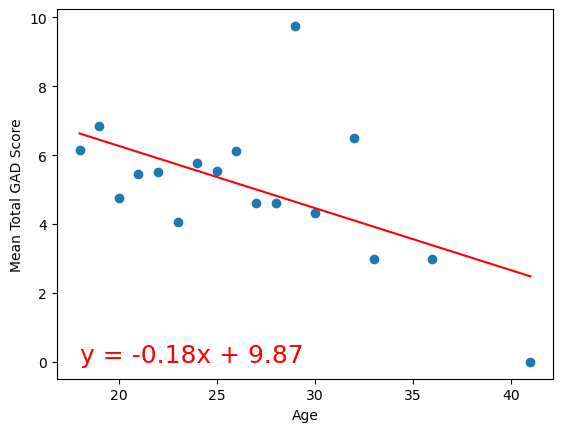

In [90]:
gad_regression = plot_linregress(agg_swl_rpg.index, agg_swl_rpg['GAD Total']['mean'],'Age', 'Mean Total GAD Score')
print(f'Pearson correlation is {gad_regression}')

Pearson correlation is 0.40889192062950314


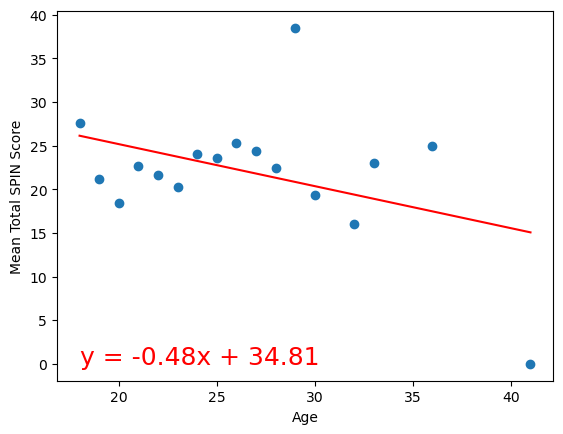

In [91]:
spin_regression = plot_linregress(agg_swl_rpg.index, agg_swl_rpg['SPIN Total']['mean'],'Age', 'Mean Total SPIN Score')
print(f'Pearson correlation is {spin_regression}')